```{python}

import folium
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import display
from ipywidgets import Layout, Button, IntProgress, Output, HBox, VBox, HTML, interactive, SelectionRangeSlider

```
# Aggregate of ORNL DAAC Soil Moisture Visualizer outputs

In [34]:
import os
import json
import warnings
from math import ceil
from io import StringIO
from datetime import datetime

import folium
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from shapely.geometry import shape

## Random stuff

In [2]:
disabled_sources =  ["FLUXNET", "MODIS", "GRACE", "PBOH2O"]

smvdownload = "https://airmoss.ornl.gov/cgi-bin/viz/api/download.pl?"
smvdatasets = pd.read_csv(
    "docs/smvdatasets.csv", 
    index_col="dataset", 
    header=0)

download_msg = """<p style="text-align:center;">Click <b>Submit</b> to downloa
d Soil Moisture Visualizer data for this site.<br></p>"""

numvalid = lambda v: np.count_nonzero(~np.isnan(v.data))
allnan = lambda v: numvalid(v)==0

node_header = ["id", "lat", "lon", "node"]
layer_header = ["id", "lat", "lon", "layer", "nodes", "points", "xr"]

## Workflow

### Reading layers

In [25]:
def get_colors(n, cmap=cm.Set2):
    """ 
    Takes integer count of colors to map and optional kwarg: 
      'cmap=matplotlib.cm.<cmap>'.
    """

    cspace = np.linspace(0.0, 1.0, n)           # *1
    rgb = cmap(cspace)                          # *2
    cols = [colors.to_hex(c[0:3]) for c in rgb] # *3

    return(cols)


def from_geojson(input_geojson):
    """ """
    
    with open(input_geojson, "r") as f:
        shapes = json.load(f)
    features = shapes["features"]
    cols = get_colors(len(features))
    
    return((features, cols))

Plot some sites on a map

In [ ]:
shapes = "docs/usfs_sites/Sites_lf_geo.json"

features, cols = from_geojson(shapes)        # get features and cols

def get_layer_data(i, feat, col="#FFFFFF", opac=0.4, samp=True):
    """ """

    shapely_geom = shape(feat["geometry"])              # shapely geom
    nodes = get_ease(shapely_geom) if samp else None     # ease grid points
    nodes["node"] = [Node(
        i, row["lat"], row["lon"]
    ) for i, row in nodes.iterrows()]
    nodes["xr"] = [None]*len(nodes.index)
    
    cent = shapely_geom.centroid                        # centroid
    lat, lon = cent.y, cent.x                           # lat, lon
    feat["properties"].update({"id": i, "style": {
        "weight": 0.75, 
        "color": "aliceblue",
        "fillColor": col,
        "fillOpacity": opac}})

    return((feat, lat, lon, nodes))


### EASE grid v2

In [35]:
latf = "docs/EASE2_M09km.lats.3856x1624x1.double"
lonf = "docs/EASE2_M09km.lons.3856x1624x1.double"

lats = np.fromfile(latf, dtype=np.float64).flatten() 
lons = np.fromfile(lonf, dtype=np.float64).flatten()

crds = np.dstack((lats,lons))[0]
crds.shape

(6262144, 2)

In [3]:
def get_ease(shapely_geom):
    """ """

    bnds = shapely_geom.bounds 
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds

    ease_table = {"id":[], "lat":[], "lon":[], "tup":[], "in":[]}
    for i, p in enumerate(ease):
        
        ease_table["id"].append(i)
        ease_table["lat"].append(p[0])
        ease_table["lon"].append(p[1])
        ease_table["tup"].append((p[0], p[1]))
        
        shapely_pt = shape({                  # input to shapely.shape is a
            "type": "Point",                  # python dict equivalent of
            "coordinates": (p[1], p[0])})     # geojson point geometry
        
        if shapely_geom.contains(shapely_pt): # if point inside poly
            ease_table["in"].append(True)
        else:
            ease_table["in"].append(False)
        
    return(pd.DataFrame(ease_table))

map some points

In [ ]:
import cartopy.crs as ccrs

lon, lat = poly.xr.lon, poly.xr.lat

x2d, y2d = np.meshgrid(lon, lat)

ax = plt.subplot(projection=ccrs.Orthographic(poly.lon, poly.lat));
ax.scatter(x2d, y2d, transform=ccrs.Orthographic(poly.lon, poly.lat));

data = {
    'type': 'FeatureCollection',
    'features': [
        {
            'type': 'Feature',
            'geometry': {
                'type': 'MultiPoint',
                'coordinates': [[lon, lat] for (lat, lon) in zip(lats, lons)],
            },
            'properties': {'prop0': 'value0'}
        },
    ],
}

m = folium.Map([48, 5], zoom_start=6)
m.add_child(features.GeoJson(data))

### Translate tables to multidimensional spatial format

In [4]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                      # get file from string

    df = pd.read_csv(
        f, 
        header=4, 
        index_col="time",
        error_bad_lines=False, 
        warn_bad_lines=False)                        # read to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)           # split col by ;
    df = df.replace('', np.nan)                       # set '' to nan
    df = df.astype(float)                             # set all to float
    df.columns = ["Min","Mean","Max"]                 # add column names
    
    return(df)


def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""

    a = smvdatasets.loc[dataset].to_dict()
    x = xr.DataArray(df, name=dataset, attrs=a)
    x = x.rename(dict(dim_1="stat"))
    
    return(x)


def get_coords(node):
    """ """

    n = xr.DataArray(data=[node.id], dims=["node"])
    
    y = xr.DataArray(data=[node.lat], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude coordinate",
        units="degrees_north"))
    
    x = xr.DataArray(data=[node.lon], coords=[n], dims=["node"], attrs=dict(
        standard_name="latitude",
        long_name="latitude",
        units="degrees_north"))
    
    return(y, x)


def get_node_xr(node, grid=True):
    """ """
        
    node.submit(session) # download the data
    df = node.df                                         # get the sample df
    
    ds = {}
    for dataset in df.columns:
        a = smvdatasets.loc[dataset].to_dict()
        if a["source"] not in disabled_sources:
            split_column = split_pd(df[dataset])
            ds[dataset] = pd_to_xr(dataset, split_column)
    
    node.grid = grid
    y, x = get_coords(node)
    xds = xr.merge(ds.values())                          # merge to one xr
    xds = xds.assign_coords(lat=y, lon=x)                # add coord arrays
        
    return(xds)

### Node class

In [6]:
class Node(object):
    """ """

    off = {"fill_opacity": 0.4, "stroke": False}

    
    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        
        self.id = i
        self.lat = lat 
        self.lon = lon

        self.on = False
        self.dl = smvdownload+"lt={0}&ln={1}&d=smap".format(lat, lon)

        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)


    #def toggle(self, event, type, coordinates):
    #    style = self.off if self.on else self.symbology   # determine opacity
    #    self.update(**style)                              # set opacity
    #    self.on = False if self.on else True              # toggle status

    
    def submit(self, session):
        """Called by parent. Downloads url. Updates status."""

        self.response = session.get(self.dl)
        self.df = txt_to_pd(self.response.text)            # read to
        #self.pt.on_click(self.toggle)                      # callback toggle
        #self.summary = get_null_summary(self.xr)           # get null summary
        #self.symbology = get_symbology(self.summary[0])
        self.on = True                                     # toggle status on

### Layer parser

In [22]:
def get_layer_data(i, feat, col="#FFFFFF", opac=0.4, samp=True):
    """ """

    shapely_geom = shape(feat["geometry"])              # shapely geom
    nodes = get_ease(shapely_geom) if samp else None     # ease grid points
    nodes["node"] = [Node(
        i, row["lat"], row["lon"]
    ) for i, row in nodes.iterrows()]
    nodes["xr"] = [None]*len(nodes.index)
    
    cent = shapely_geom.centroid                        # centroid
    lat, lon = cent.y, cent.x                           # lat, lon
    feat["properties"].update({"id": i, "style": {
        "weight": 0.75, 
        "color": "aliceblue",
        "fillColor": col,
        "fillOpacity": opac}})

    return((feat, lat, lon, nodes))


class Layer(object):
    """ """

    def __init__(self, i, feat, col=None, grid=True):
        """ """
        
        layer_data = get_layer_data(i, feat, col)
        
        self.id = i
        self.feat = layer_data[0]
        self.lat = layer_data[1]
        self.lon = layer_data[2]
        self.nodes = layer_data[3]
        self.grid = grid

        #self.layer = GeoJSON(
        #    data=self.feat,
        #    hover_style={
        #        "color": "white", 
        #        "fillOpacity": 0.8})
        #self.layer.on_click(self.toggle)

        self.dl = False    # downloaded or nah?
        self.on = False    # toggle on or nah?

        
    #def toggle(self, **kwargs):
    #    """Routine for when a new USFS polygon is selected."""
    #    if list(kwargs.keys()) != ['event', 'properties']: # check event
    #        return(None)                                   # skip basemap
    #    self.on = False if self.on else True               # update status
    
    
    def submit(self, session):
        """ """
        
        for i, node in self.nodes.iterrows():                  # loop over sample pts
            if not node["node"].on:              
                self.nodes.at[i,"xr"] = get_node_xr(
                    node["node"], 
                    grid=self.grid)  # get xr dataset
        
        self.xr = xr.concat(self.nodes["xr"].tolist(), "node")  # make xr dataset
    
    
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    
    #def tonode(self):
    #    """ """
    #
    #    self.xr.concat()
    
    def toxy(self):
        """ """    
        
        self.xr = self.xr.set_index({"node": ["lat", "lon"]})
        self.xr = self.xr.unstack()


## Launch

In [8]:
from ursjupyter import *

poly = Layer(1, features[1])            # get Layer class
poly.submit(session)

poly.xr

'Login successful. Download with: session.get(url)'

<xarray.Dataset>
Dimensions:                     (node: 48, stat: 3, time: 6240)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-05-01
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * node                        (node) int64 0 1 2 3 4 5 6 ... 42 43 44 45 46 47
    lat                         (node) float64 31.91 31.91 31.91 ... 31.34 31.34
    lon                         (node) float64 -110.8 -110.7 ... -110.4 -110.3
Data variables:
    SoilSCAPE_surface           (node, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (node, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (node, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (node, time, stat) float64 nan nan ... nan nan
    SMAP_rootzone             

Dump to pickle file for backup:

In [9]:
try:
    import _pickle as pickle
except ModuleNotFoundError:
    import pickle
    
with open('docs/feat1.pkl', 'wb') as output:
    pickle.dump(poly, output, -1)

## Explore the data

Use <Layer>.toxy() to switch from node structure to raster structure:

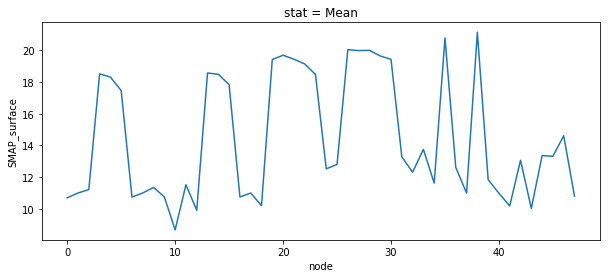

In [14]:
plt.rcParams["figure.figsize"] = (10,4)

poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").plot(figsize=(10, 4))

In [16]:
poly.toxy()
poly.xr

C:\Apps\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


<xarray.Dataset>
Dimensions:                     (lat: 8, lon: 6, stat: 3, time: 6240)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-05-01
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * lat                         (lat) float64 31.34 31.42 31.5 ... 31.83 31.91
  * lon                         (lon) float64 -110.8 -110.7 ... -110.4 -110.3
Data variables:
    SoilSCAPE_surface           (time, stat, lat, lon) float64 nan nan ... nan
    SoilSCAPE_rootzone          (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_surface        (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L2_3_rootzone       (time, stat, lat, lon) float64 nan nan ... nan
    AirMOSS_L4_rootzone         (time, stat, lat, lon) float64 nan nan ... nan
    SMAP_surface                (time, stat, lat, lon) float64 nan nan ... 13.69
    SMAP_rootzone               (time, stat, lat, lon) float64 nan nan ... 25.57
    NEE_mean             

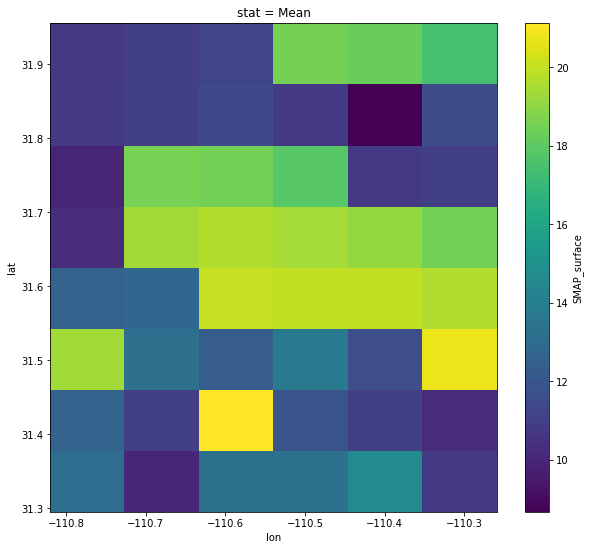

In [21]:
poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").plot(figsize=(10,9))

In [23]:
#poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").plot()

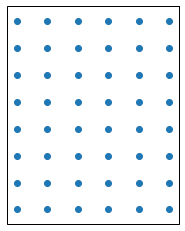

In [24]:
import cartopy.crs as ccrs

lon, lat = poly.xr.lon, poly.xr.lat

x2d, y2d = np.meshgrid(lon, lat)

ax = plt.subplot(projection=ccrs.Orthographic(poly.lon, poly.lat));
ax.scatter(x2d, y2d, transform=ccrs.Orthographic(poly.lon, poly.lat));

In [ ]:
lat.data.min()

#### Folium map

In [33]:
from folium.plugins import MiniMap

m = folium.Map([poly.lat, poly.lon], zoom_start=9, tiles='Cartodb Positron',)
minimap = MiniMap(toggle_display=True)
m.add_child(minimap)


image = poly.xr["SMAP_surface"].sel(stat="Mean").mean("time").data

folium.raster_layers.ImageOverlay(
    image=image,
    bounds=[
        [lat.data.min() , lon.data.min()], 
        [lat.data.max() , lon.data.max()]],
    mercator_project=True,
    colormap=cm.viridis,  
    opacity=0.75
).add_to(m)

m

https://python-visualization.github.io/folium/modules.html#folium.raster_layers.ImageOverlay

In [ ]:
m = folium.Map([poly.lat, poly.lon], zoom_start=9, tiles='Cartodb Positron',)
folium.features.GeoJson(shapes).add_to(m)

m

In [ ]:
m = folium.Map(
    location=[40, 10],
    zoom_start=4,
    control_scale=True,
    prefer_canvas=True
)


def style_function(feature):
    return {
        'fillColor': '#ffaf00',
        'color': 'blue',
        'weight': 1.5,
        'dashArray': '5, 5'
    }


def highlight_function(feature):
    return {
        'fillColor': '#ffaf00',
        'color': 'green',
        'weight': 3,
        'dashArray': '5, 5'
    }


for index, row in df.iterrows():
    c = folium.GeoJson(
        row['geojson'],
        name=('{}{}'.format(row['dep'], row['dest'])),
        overlay=True,
        style_function=style_function,
        highlight_function=highlight_function
    )
    folium.Popup('{}\n{}'.format(row['dep'], row['dest'])).add_to(c)
    c.add_to(m)

folium.LayerControl().add_to(m)
m.save(os.path.join('results', 'Highlight_Function.html'))

m

# @FG------------------------------------------------------------

In [ ]:
xrds = 
poly.xr = xrds
polymult = poly.xr.set_index({"node": ["lat", "lon"]})
polyxy = polymult.unstack()
polyxy

In [ ]:
polyxy["SMAP_surface"].sel(stat="Mean").mean("time").plot()

In [ ]:

bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)    # map widget 

map_args = dict(
    center=(32.75, -109), 
    zoom=7, 
    scroll_wheel_zoom=True)

submit_args = dict(                                            # submit button
    description="Submit", 
    disabled=True, 
    button_style="success")

progress_args = dict(                                          # progress bar
    description="Progress: ", 
    layout=Layout(width="95%"))

# Original NASA-USFS Workshop widget

In [ ]:
%matplotlib widget
from ursjupyter import *
from smvjupyter import *
warnings.filterwarnings('ignore')

usfs_sites = "docs/usfs_sites/Sites_lf_geo.json"                      # USFS sites
usfs_regions = "docs/usfs_admin/USFS_admin_boundaries.json"           # USFS administrative regions

In [ ]:
#app = JupyterSMV(usfs_sites, anc=usfs_regions, session=session)